# Data coverage & quality

In this notebook we will go through the data tables that are used in analytics and modeling and check the coverage and quality of the data.

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from box import Box
from google.cloud import bigquery

In [2]:
# -------------------- GLOBAL VARIABLES --------------------
PATH_TO_CONFIG_FILE = '../config.yml'

# -------------------- LOAD CONFIGURATION --------------------
# Load the configuration file
config = Box.from_yaml(filename=PATH_TO_CONFIG_FILE)
# Initialize a BigQuery client
client = bigquery.Client(project=config.GCP.PROJECT_ID)
# Set the BigQuery dataset schema
read_schema = config.GCP.READ_SCHEMA
ingestion_schema = config.GCP.INGESTION_SCHEMA
analytics_schema = config.GCP.ANALYTICS_SCHEMA

# Define the color palette
palette = {'good': config.DASHBOARD.COLORS.GOOD_COLOR,
           'warning': config.DASHBOARD.COLORS.WARNING_COLOR,
           'bad': config.DASHBOARD.COLORS.BAD_COLOR}
DEFAULT_VALUE = 'n/a'

In [18]:
def column_coverage(series: pd.Series, default_value: str) -> float:
    """
    Calculate the coverage of a column in percentage.
    :param series: Pandas Series
    :param default_value: Default value to be considered as missing
    :return: Coverage of the column in percentage
    """
    # Calculate the coverage of the column in percentage by dividing the number 
    # of non-default values to the total number of values
    coverage = series[series != default_value].shape[0] / series.shape[0] * 100
    return coverage


def table_health(df: pd.DataFrame, default_value: str) -> pd.DataFrame:
    """
    Calculate the health metrics of a DataFrame.
    :param df: Pandas DataFrame
    :param default_value: Default value to be considered as missing
    :return: Health metrics of the DataFrame
    """
    # list to store the health metrics of the DataFrame
    list_table__health = []
    # Iterate over the columns of the DataFrame
    for column in df.columns:
        # Calculate the coverage of the column
        coverage = column_coverage(df[column], default_value)

        # Append the health metrics to the DataFrame
        list_table__health.append(
            dict(column_name=column,
                 coverage=coverage)
        )

    # Return the health metrics as a DataFrame sorted by coverage
    return pd.DataFrame(list_table__health).sort_values(by='coverage', ascending=False)


# Define the color mapping based on coverage
def get_color_label(coverage):
    """
    Get the color label based on the coverage percentage.
    :param coverage: Coverage percentage
    :return: Color label
    """
    if coverage > 90:
        return 'good'
    elif coverage > 70:
        return 'warning'
    else:
        return 'bad'


def plot_health_metrics(df_source: pd.DataFrame, table_name: str, default_value: str, palette: dict):
    """
    Plot the health metrics of a DataFrame.
    :param df_source: Pandas DataFrame to be analyzed
    :param table_name: Name of the table
    :param default_value: Default value to be considered as missing
    :param palette: Color palette 
    """
    # Calculate the health metrics of the table
    df_health = table_health(df=df_source,
                             default_value=default_value)

    # Visualize the health metrics using a bar chart with the coverage on the y-axis.
    # We use 'good' color for coverage above 90%, 'warning' color for coverage between 70% and 90%
    # and 'bad' color for coverage below 70%.

    # Apply the function to create a new column for color labels
    df_health['color_label'] = df_health['coverage'].apply(get_color_label)

    # Create the bar plot with data labels with hue based on the color labels
    ax = sns.barplot(x='coverage', y='column_name', data=df_health,
                     hue='color_label', palette=palette, dodge=False, legend=False)
    # Add the data labels to the plot (truncated to 0 decimal points)
    for container in ax.containers:
        ax.bar_label(container, fmt='%.0f', label_type='edge')
    plt.xlabel('Coverage (%)')
    plt.ylabel('Column')
    # Set the title of the plot
    plt.title(f'{table_name} - Health Metrics')


## DIM_ARTICLE

Read the `DIM_ARTICLE` table from the BigQuery dataset and output first few rows of the table to understand what the data looks like.

In [8]:
query_article = f"""
SELECT
    *
FROM
    {read_schema}.DIM_ARTICLE
"""

df_article = client.query(query_article).to_dataframe()
df_article.head(10)

,ARTICLE_SID,ARTICLE_DOI,ARTICLE_URL,ARTICLE_FUNDER,ARTICLE_INSTITUTION,ARTICLE_PUBLISHER,ARTICLE_TITLE,ARTICLE_SHORT_TITLE,ARTICLE_SUBTITLE,ARTICLE_ORIGINAL_TITLE,ARTICLE_CONTAINER_TITLE,ARTICLE_SHORT_CONTAINER_TITLE,ARTICLE_ABSTRACT,ARTICLE_PUBLICATION_DT
0,0c24c44346309da4fa6d3c1c8479512a,10.3390/w15081452,http://dx.doi.org/10.3390/w15081452,2023 Development Fund of the UBB,n/a,MDPI AG,Determination of Runoff Curve Numbers for the ...,n/a,n/a,n/a,Water,Water,<jats:p>The NRCS-CN (Natural Resources Conserv...,2023-04-07
1,b7906a6f0c3c540cac623a028cab7aa9,10.1007/s00253-016-7667-5,http://dx.doi.org/10.1007/s00253-016-7667-5,Bundesministerium für Bildung und Forschung,n/a,Springer Science and Business Media LLC,Design of a covalently linked human interleuki...,n/a,n/a,n/a,Applied Microbiology and Biotechnology,Appl Microbiol Biotechnol,n/a,2016-07-18
2,979b1701fbe8079cfd3e2ef386faa061,10.1200/jco.2018.36.5_suppl.69,http://dx.doi.org/10.1200/jco.2018.36.5_suppl.69,n/a,n/a,American Society of Clinical Oncology (ASCO),Preliminary biomarker and pharmacodynamic data...,n/a,n/a,n/a,Journal of Clinical Oncology,JCO,<jats:p> 69 </jats:p><jats:p> Background: HER2...,2018-02-10
3,1c57e9fdb99b5396402bbf6676d38241,10.1016/s0169-4758(98)01321-0,http://dx.doi.org/10.1016/s0169-4758(98)01321-0,n/a,n/a,Elsevier BV,Schistosomes: Unanswered Questions on the Basi...,n/a,n/a,n/a,Parasitology Today,Parasitology Today,n/a,1998-10-01
4,b2f49adb4723d0f49a3dde4d9ea517d9,10.1177/0145721715587743,http://dx.doi.org/10.1177/0145721715587743,n/a,n/a,SAGE Publications,Preteen-Parent Experiences With PREP-T1 Feasib...,n/a,n/a,n/a,The Diabetes Educator,Diabetes Educ,<jats:sec><jats:title>Purpose</jats:title><jat...,2015-05-25
5,d43b3ee1c5a465cb1870e58bb8e076e3,10.1002/9781118792148.ch381,http://dx.doi.org/10.1002/9781118792148.ch381,n/a,n/a,Wiley,Analysis of Electromagnetic Field and Temperat...,n/a,n/a,n/a,PRICM,n/a,n/a,2013-08-16
6,f18cdd5bece2e35e390a46d4fe5a3d17,10.1024//0044-3514.32.1.29,http://dx.doi.org/10.1024//0044-3514.32.1.29,n/a,n/a,Hogrefe Publishing Group,Skalen zum Investitionsmodell von Rusbult,n/a,n/a,n/a,Zeitschrift für Sozialpsychologie,Zeitschrift für Sozialpsychologie,<jats:p> Zusammenfassung: Das Investitionsmode...,2001-03-01
7,df4df44ccad6a66cbc9d87018a55542c,10.1007/bf01179788,http://dx.doi.org/10.1007/bf01179788,n/a,n/a,Springer Science and Business Media LLC,On property B and on Steiner systems,n/a,n/a,n/a,Mathematische Zeitschrift,Math Z,n/a,1977-06-01
8,81603aa31863be633a82fe2f7cf9a577,10.1007/s00704-016-1971-y,http://dx.doi.org/10.1007/s00704-016-1971-y,n/a,n/a,Springer Science and Business Media LLC,Evaluating the performance of ENVI-met model i...,n/a,n/a,n/a,Theoretical and Applied Climatology,Theor Appl Climatol,n/a,2016-11-05
9,a88cef05d7adf8375315684b8e7131cf,10.1016/j.sigpro.2009.11.031,http://dx.doi.org/10.1016/j.sigpro.2009.11.031,n/a,n/a,Elsevier BV,Local quaternion Fourier transform and color i...,n/a,n/a,n/a,Signal Processing,Signal Processing,n/a,2010-06-01


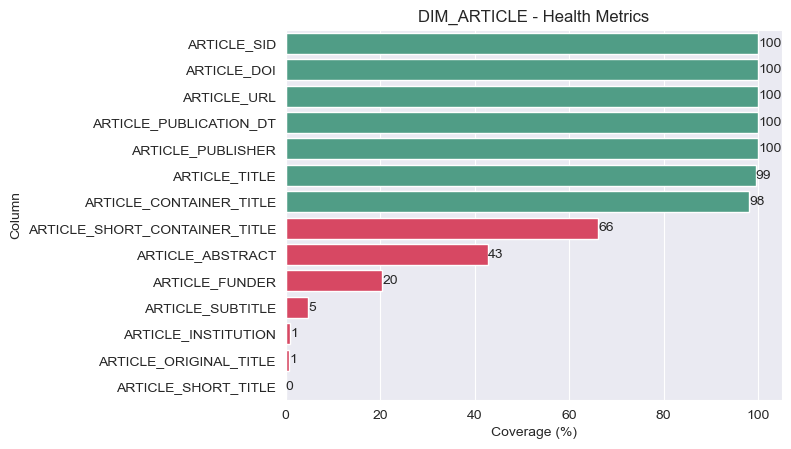

In [19]:
plot_health_metrics(df_source=df_article,
                    table_name='DIM_ARTICLE',
                    default_value=DEFAULT_VALUE,
                    palette=palette)

## DIM_AUTHOR
Read the `DIM_AUTHOR` table from the BigQuery dataset and output first few rows of the table to understand what the data looks like.

In [21]:
query_author = f"""
SELECT
    *
FROM
    {read_schema}.DIM_AUTHOR
"""

df_author = client.query(query_author).to_dataframe()
df_author.head(10)

,AUTHOR_SID,AUTHOR_FULL_NAME,AUTHOR_ORCID_ID
0,fc587f3924366e7b610dcd727f2677a7,Susan Ashton,n/a
1,c931c9233191e529780223ede23027a8,Patience Adjepong,n/a
2,e48914a1703b024a04629dd272ae04b0,Zhengtang Luo,n/a
3,e9914111bcdbf3d46a54d9c5e416b96d,Durgesh H. Salunkhe,n/a
4,f6b5b4e881b29d5fcd0059695c4900dd,Maksim I. Hulnik,n/a
5,72eaf646725994c6ef344fc2e31a8ae5,M. Vojinovic,n/a
6,7698b8ea5f6e985da3a7f97b4434f510,Leonardo Nicola Martin Iasi,n/a
7,8c70a34d783a5eb61ac9725dbee8d934,Magali Duvail,n/a
8,8d0c4fe8638479ee2d0e89e96f95ffb0,X. Jin,n/a
9,98a18bae82d4f8e0d2181445d3d4ca0b,F. Ebertz,n/a


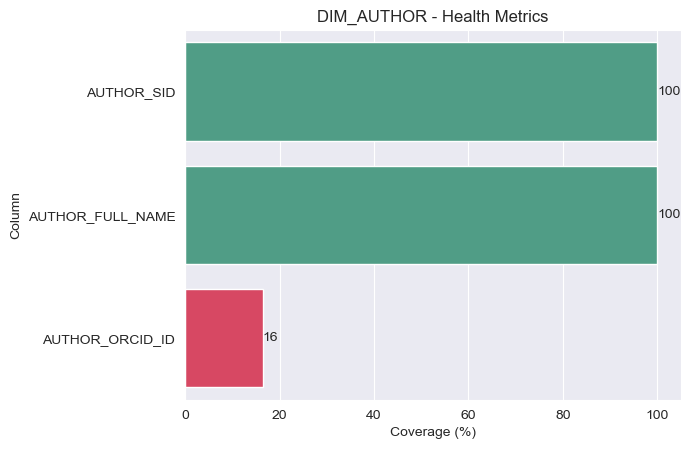

In [28]:
plot_health_metrics(df_source=df_author,
                    table_name='DIM_AUTHOR',
                    default_value=DEFAULT_VALUE,
                    palette=palette)

## FCT_COLLABORATION
Read the `FCT_COLLABORATION` table from the BigQuery dataset and output first few rows of the table to understand what the data looks like.

In [22]:
query_collaboration = f"""
SELECT
    *
FROM
    {read_schema}.FCT_COLLABORATION
"""

df_collaboration = client.query(query_collaboration).to_dataframe()
df_collaboration.head(10)

,ARTICLE_SID,AUTHOR_SID,INSTITUTION_SID,ARTICLE_PUBLICATION_DT,IS_SOLE_AUTHOR_PUBLICATION,IS_INTERNAL_COLLABORATION,IS_EXTERNAL_COLLABORATION,IS_EUTOPIAN_COLLABORATION,IS_EUTOPIAN_PUBLICATION,IS_NEW_COLLABORATION,PK_COLLABORATION
0,13a943bfe8963bc80b3f8991facd4e4d,f0730bc355b06fcf0559e84a7f8fa5b2,n/a,2019-01-25,False,True,False,False,False,False,6ff22b8ace1e064a9adf122d9ef48353
1,f353ca9d978ee866b2f4131edb5c77bd,2701e2ac88d42dcdaed03af9156960b9,VUB,2021-11-29,True,False,False,False,True,False,0bffcb205afaddb1cf4ecb5da31040f9
2,6f9a821c433e415d8c487610301a8c9b,ecd69dca246edef52a9af3289f7c892a,n/a,1989-01-01,False,True,False,False,False,False,34070c2a8671dd731c214a14214de7d6
3,b5c6bd25215a608c912dd4c134b0b809,c193e74bbfa6532d101a9fe9877ec76d,n/a,2020-07-18,False,True,False,False,False,False,ab041ee3a85c3dadf92dfeb17935081a
4,93fc9108aa3c488e5df43b597072cf8b,d48049955a17bfd5cc1e1ee16df5a15b,n/a,2017-10-01,False,True,False,False,False,False,717950c1701d4708fea87951578ac376
5,c96e623458daea3a5c5b319fc16a051f,8cb07a3901fecd5aeed483abf5bfaa1b,OTHER,2022-08-28,False,True,False,False,False,False,d2f8ca2de84ea316266314a634ed39e1
6,ab8b7c8878ca7c62db71fa372f214c19,c8c813f1b2eb2ac3e85a3facc6818cfe,n/a,2010-10-01,False,True,False,False,False,False,830798da361d8587d09aa0f56d5633ac
7,4f9a21db7e95e4405a356da836a82acb,a7170f720c594cd7e2b504e5f61fedfe,n/a,2003-01-17,False,True,False,False,False,False,1b9e97c4293ac593624624ff1dce019f
8,77f8af77d0f6d89913e8c2a61a113a72,efa7ead7f430bd3c5af318d2d46e955c,n/a,2021-12-23,False,True,False,False,False,False,7df8cc0b2dddbc038ac1cfea005227d8
9,36e1003f595b79ae390e32ecb873bf42,0c4734791505d7e284866dca028c762c,n/a,2014-12-21,False,True,False,False,False,False,10d2991dd4bc67f58b52cff2989c77ef


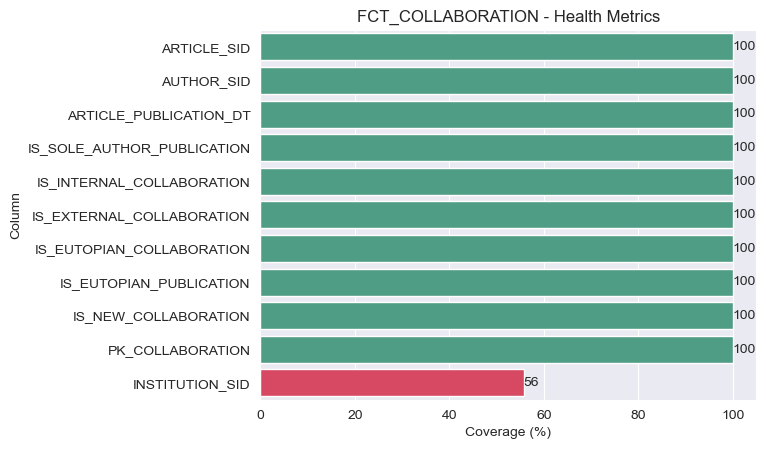

In [27]:
plot_health_metrics(df_source=df_collaboration,
                    table_name='FCT_COLLABORATION',
                    default_value=DEFAULT_VALUE,
                    palette=palette)

## FCT_COLLABORATION_NOVELTY
Read the `FCT_COLLABORATION_NOVELTY` table from the BigQuery dataset and output first few rows of the table to understand what the data looks like.

In [23]:
query_collaboration_novelty = f"""
SELECT
    *
FROM
    {read_schema}.FCT_COLLABORATION_NOVELTY
"""

df_collaboration_novelty = client.query(query_collaboration_novelty).to_dataframe()
df_collaboration_novelty.head(10)

,ARTICLE_SID,COLLABORATION_NOVELTY_INDEX,IS_NEW_COLLABORATION,PK_COLLABORATION_NOVELTY
0,ff5acfd534a4023e1cea29a4bef1c88d,2.0,False,6b8319c1211b6cb65bc52caa6f48f05e
1,c46ff7a2ca41cda1cdd13bfdd6d94915,2.0,False,dac3482ff5dfadd65a2c5ce7f11489e1
2,f7e5ed121ffbdf16c2bd1146faaa0530,2.0,False,43f98349c053ca88746633caf3881e30
3,bcbbf3a93c8c3ae6285f4d2d26c76f71,2.0,False,ffec1c1bc92fbd00746f248d360e7a98
4,25d57bc38204d9483be21bc12ad1882f,2.5,False,9d9962da3fc1c1b2968d42f53af5988b
5,73fc27c6d2067d20dfd9064a7c13b8b7,2.5,False,b1b714dfebebcc984494644168115609
6,5feb4dfbfdcbf7963318822e52234103,2.5,False,b939482415ffa48cda4e73259317fc48
7,34ad53cac2a6bdf2cbca4229c6274026,2.5,False,ee211d69b686d04f53888ef20e94524f
8,8f14515fa53288e8edccbc5321999f95,2.5,False,2298fd70a7f3e9fc2957e8948be3a789
9,24b7d9f15c0b98f1a3f3f508644a00f5,2.5,False,ed24bb888db115e1614f0dc02a1f6dc4


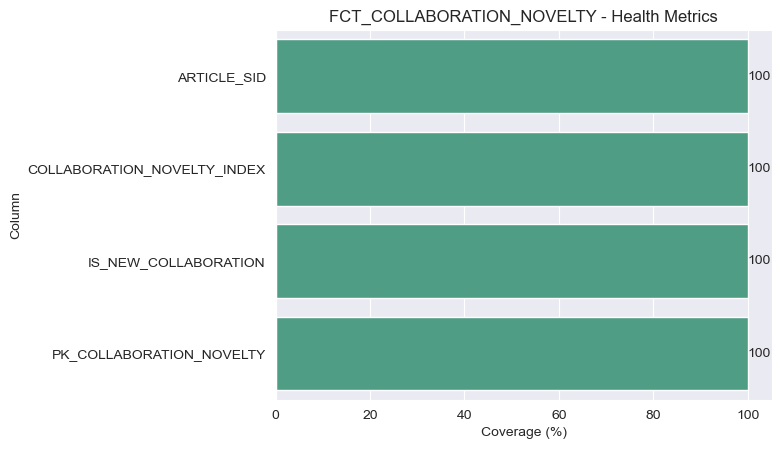

In [26]:
plot_health_metrics(df_source=df_collaboration_novelty,
                    table_name='FCT_COLLABORATION_NOVELTY',
                    default_value=DEFAULT_VALUE,
                    palette=palette)

## FCT_ARTICLE_TOPIC
Read the `FCT_COLLABORATION_TYPE` table from the BigQuery dataset and output first few rows of the table to understand what the data looks like.

In [24]:
query_article_topic = f"""
SELECT
    *
FROM
    {read_schema}.FCT_ARTICLE_TOPIC
"""

df_article_topic = client.query(query_article_topic).to_dataframe()
df_article_topic.head(10)

,ARTICLE_SID,RESEARCH_TOPIC_SID,RANK,PK_ARTICLE_TOPIC
0,cef09ce3e821ba425ec7f8f0c9236f04,0cbbb54371c016770e74aa3c528085f6,1,73040a4d12810e5d5663dce02e45f711
1,8e3e40810bdde8cd786891e5d3944f6d,1dedd3ef9e6254029063ddf2eb64bfcc,1,5db6148d03030e1b89de9e50b490eb96
2,25157e00c174f3cae6131d1521915220,1dedd3ef9e6254029063ddf2eb64bfcc,1,0eece02a73a90c83f0f052b5d83cee20
3,069b95f00ee6d66f69d9f4a4579a2d07,d041faf97759c83cb90efe840a9b4ab0,1,491586a8a19e6f7f77c86195bad20c3a
4,24a11c049e43b4c8c527e3a13ebaf3e5,d041faf97759c83cb90efe840a9b4ab0,1,b9611e717d7deb3f2fa6187d2a705e02
5,44e91ed3898c2b173d3cdec95760de0f,d041faf97759c83cb90efe840a9b4ab0,1,f6b4c58894d926787262c826dd1afaed
6,1750aac9bb515ec01c4d8aa5f5968bcd,d041faf97759c83cb90efe840a9b4ab0,1,a885aabc8ff00557e61a39fdbc24663d
7,b062fb84185b298f8da44dc87b929934,d041faf97759c83cb90efe840a9b4ab0,1,cd8e7168e70a39d823f30d5ef5dbbb76
8,d28bd1ffcf08495c283166ba354a68d1,d041faf97759c83cb90efe840a9b4ab0,1,fe5333f87f40f057cab09a8f09935fbc
9,23100d9a855d45dd1013d9d75f5dd05d,d041faf97759c83cb90efe840a9b4ab0,1,2af617273863f2ddb94ff3ff3b90177b


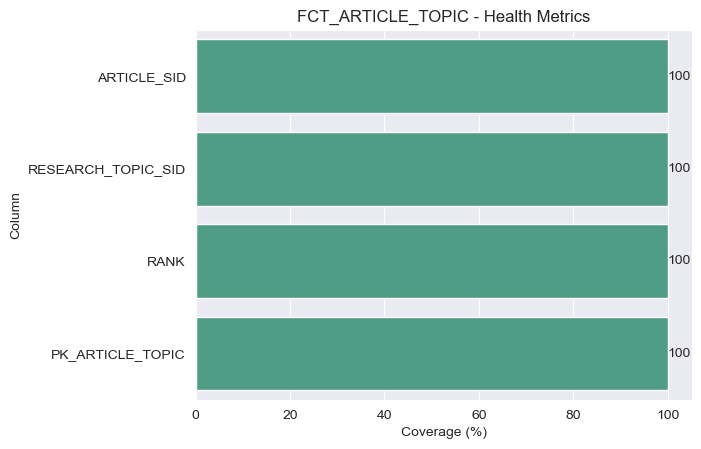

In [25]:
plot_health_metrics(df_source=df_article_topic,
                    table_name='FCT_ARTICLE_TOPIC',
                    default_value=DEFAULT_VALUE,
                    palette=palette)